# Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [3]:
def import_data(file_name, parsed=True):
        
    data = open(f"{file_name}", 'r', encoding='utf-8').read()
    pairs = [token.split('\t') for token in data.split('\n')]
    
    return pairs    

In [9]:
text_pairs = import_data('/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/parse_dataset.txt')

In [14]:
import random

random.Random(10).shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

In [21]:
with open("train.txt","w+", encoding="utf-8") as f_out:
    for pair in train_pairs:
        try:
            f_out.write(f"{pair[0].lower()}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)

with open("dev.txt","w+", encoding="utf-8") as f_out:
    for pair in val_pairs:
        try:
            f_out.write(f"{pair[0].lower()}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)

with open("test.txt","w+", encoding="utf-8") as f_out:
    for pair in test_pairs:
        try:
            f_out.write(f"{pair[0].lower()}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)

In [21]:
train_pairs =  import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/baseline/train.txt")
val_pairs = import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/baseline/dev.txt")
test_pairs = import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/baseline/test.txt")

## Phonological Normalization

In [5]:
import json

morphology = json.loads(open("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/source/morphology.json", "r", encoding='utf-8').read())

In [17]:
def phonological(instance):

    token = re.escape(instance[0].lower())

    feats = instance[1]

    lemma = re.escape(feats.split("+")[0])

    token_select = token[:len(lemma)]+"("+token[len(lemma):]+")"

    
    f_list = feats.split("+")[2:]


    for feat in f_list:
    
        try:
            if feat.startswith("DB^"):
                continue

            def wrap(term):

                token = term.group(2)
                prev = term.group(1)
                if len(morphology[feat]) == 4:
                    regex_morph1, regex_sub1,regex_morph2, regex_sub2 = morphology[feat]
                    token = re.sub(regex_morph1, regex_sub1, token)
                    token = re.sub(regex_morph2, regex_sub2, token)

                elif len(morphology[feat]) == 6:
                    regex_morph1, regex_sub1,regex_morph2, regex_sub2, regex_morph3, regex_sub3 = morphology[feat]
                    token = re.sub(regex_morph1, regex_sub1, token)
                    token = re.sub(regex_morph2, regex_sub2, token)
                    token = re.sub(regex_morph3, regex_sub3, token)

                else:
                    regex_morph, regex_sub = morphology[feat]
                    token = re.sub(regex_morph, regex_sub, token)

                return prev+token

            token = re.sub("("+token[:len(lemma)]+")("+token[len(lemma):]+")", wrap, token)
        except:
            print(token)

    return (token, instance[1], instance[2])

In [18]:
phonological(total_pairs[210])

('olAbilDIysAm',
 'ol+VERB+Polarity=Pos+Proper=False+DB^VERB+Derivation=Able+Polarity=Pos+TenseAspectMood=Past+Copula=CndCop+PersonNumber=V1sg+Proper=False',
 'tr-forum:00000353:S041')

In [19]:
train_pairs_normalized = [phonological(p) for p in train_pairs]
val_pairs_normalized = [phonological(p) for p in val_pairs]
test_pairs_normalized = [phonological(p) for p in test_pairs]

i̇ng\.
i̇ng\.
i̇ng\.
i̇ng\.


In [36]:
train_pairs_normalized =  import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/normalized/train_normalized.txt")
val_pairs_normalized = import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/normalized/dev_normalized.txt")
test_pairs_normalized = import_data("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/normalized/test_normalized.txt")

In [89]:
with open("train_normalized.txt","w+", encoding="utf-8") as f_out:
    for pair in train_pairs_normalized:
        try:
            f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)
with open("dev_normalized.txt","w+", encoding="utf-8") as f_out:
    for pair in val_pairs_normalized:
        try:
            f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)
with open("test_normalized.txt","w+", encoding="utf-8") as f_out:
    for pair in test_pairs_normalized:
        try:
            f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)

## Feature Normalization

In [15]:
import re
REGEX_Prop = r"\+Proper=False"
REGEX_Bare = r"\+Case=Bare\+"
REGEX_Pos  = r"\+Polarity=Pos"
REGEX_V3pl = r"^.+?(?!ler\t).+?(\+PersonNumber=V3pl)"
REGEX_A3sg = r"\+PersonNumber=A3sg"
REGEX_Pnon = r"\+Possessive=Pnon"
REGEX_Type = r"\+(Complement|Conjunction|Determiner)Type="
REGEX_Temp = r"\+Temporal=True" 
REGEX_Pron = r"PRON\+PersonNumber=A(1|2|3)(sg|pl)"   

def feature_normalization(pairs):

    updated = []
    lines = ["\t".join(pair) for pair in pairs]
    for line in lines[:-1]:

        prop = re.findall(REGEX_Prop, line)
        if prop:
            line = re.sub(REGEX_Prop,"",line)
        
        prop_t = re.findall(r"\+Proper=True", line)
        if prop_t:
            line = re.sub(r"\+Proper=True", "",line)
            line = re.sub(r"(\t[a-zçığşü]+\+\w+)\+",r"\1^PROP+",line)

        bare = re.findall(REGEX_Bare,line)
        if bare:
            line = re.sub("\+Case=Bare", "", line)

        pos = re.findall(REGEX_Pos, line)
        if pos:
            line = re.sub(REGEX_Pos, "", line)

        v3pl = re.findall(REGEX_V3pl, line)
        if v3pl:
            line = re.sub("\+PersonNumber=V3pl","", line)

        Pnon = re.findall(REGEX_Pnon, line)
        if Pnon:
            line = re.sub(REGEX_Pnon,"", line)

        Type = re.findall(REGEX_Type, line)
        if Type:
            line = re.sub(REGEX_Type,"^", line)

        Temp = re.findall(REGEX_Temp, line)
        if Temp:
            line = re.sub(REGEX_Temp,"^Temporal", line)

        Pron = re.findall(REGEX_Pron, line)
        if Pron:
            line = re.sub(REGEX_Pron,r"^PRON+A\1\2", line)

        a3sg = re.findall(REGEX_A3sg, line)
        if a3sg:
            line = re.sub(REGEX_A3sg,"", line)

        updated.append(line.split("\t"))

    return updated


In [39]:
train_pairs_feat_norm = feature_normalization(train_pairs_normalized)
val_pairs_feat_norm =   feature_normalization(val_pairs_normalized)
test_pairs_feat_norm =  feature_normalization(test_pairs_normalized)

In [26]:
idx = 10
print(train_pairs[idx])
print(train_pairs_feat_norm[idx])

['ve', 've+CONJ+ConjunctionType=Coor+Proper=False', 'http://tr.wikipedia.org/wiki/Ge%C3%A7_Hititler:S050']
['ve', 've+CONJ^Coor', 'http://tr.wikipedia.org/wiki/Ge%C3%A7_Hititler:S050']


In [40]:
with open("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/all_process/train.txt","w+", encoding="utf-8") as f_out:
    for pair in train_pairs_feat_norm:
        try:
            f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)
# with open("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/all_process/dev.txt", "w+", encoding="utf-8") as f_out:
#     for pair in val_pairs_feat_norm:
#         try:
#             f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
#         except:
#             print(pair)
# with open("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/all_process/test.txt", "w+", encoding="utf-8") as f_out:
#     for pair in test_pairs_feat_norm:
#         try:
#             f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
#         except:
#             print(pair)

## Upsampling

In [18]:
def get_tag_counts(pairs):
    try:
        morphs = [token[1] for token in pairs]
    except:
        morphs = [token[1] for token in pairs[:-1]]

    pos = [token.split("+")[1] for token in morphs if token != "?"]
    feats = [token.split("+")[2:] for token in morphs]
    feat_extend = []
    for feat in feats:
        feat_extend.extend(feat)

    return pd.Series(pos).value_counts(), pd.Series(feat_extend).value_counts()

In [19]:
pos_wiki_counts, feat_wiki_count = get_tag_counts(train_pairs[:-1])

NameError: name 'train_pairs' is not defined

In [21]:
def get_indices(pairs, POS=False ,feat=False):
    try:
        morphs = [token[1] for token in pairs]
    except:
        morphs = [token[1] for token in pairs[:-1]]

    if POS:
        pos = [token.split("+")[1] for token in morphs if token != "?"]
        pos_indices = pd.Series(pos)
        pos_indices = pos_indices[pos_indices == POS].index
        return pos_indices

    if feat:
        feats = [token.split("+")[2:] for token in morphs]
        feat_extend = []
        for feat in feats:
            feat_extend.extend(feat)

    return pd.Series(pos).value_counts(), pd.Series(feat_extend).value_counts()

In [43]:
train_pairs = train_pairs[:-1]

In [23]:
train_pairs[-1]

NameError: name 'train_pairs' is not defined

In [24]:
train_verbs = [train_pairs_feat_norm[i] for i in get_indices(train_pairs_normalized, POS='VERB')]
train_adjectives = [train_pairs_feat_norm[i] for i in get_indices(train_pairs_normalized, POS='ADJ')]

In [25]:
train_pairs_extended_v = train_pairs_normalized.copy()
train_pairs_extended_v.extend(train_verbs)

In [26]:
train_pairs_normalized=train_pairs_extended_v

In [49]:
train_pairs[-1]

['konuk',
 'konuk+NOUN+PersonNumber=A3sg+Possessive=Pnon+Case=Bare+Proper=False',
 'tr-review:00000022:S006']

In [ ]:
train_pairs_extended

In [28]:
print("Without Verb Sampling: ", str(len(train_pairs_feat_norm)))
print("With Verb Sampling: ", str(len(train_pairs_normalized)))

Without Verb Sampling:  46512
With Verb Sampling:  54702


In [29]:
pos_extend_counts, feat_extend_count = get_tag_counts(train_pairs_feat_norm)
pos_norm_counts, feat_norm_count = get_tag_counts(train_pairs_normalized)

IndexError: list index out of range

In [30]:
for (norm,ext),pos in zip(zip(pos_norm_counts,pos_extend_counts), pos_extend_counts.index):
    print(f"    {pos} & {norm} & {ext} \\\\")

NameError: name 'pos_norm_counts' is not defined

In [52]:
def plot_pos(counts):
    plt.rcParams['figure.figsize'] = [17, 15]
    plt.bar(counts.index, counts.values)

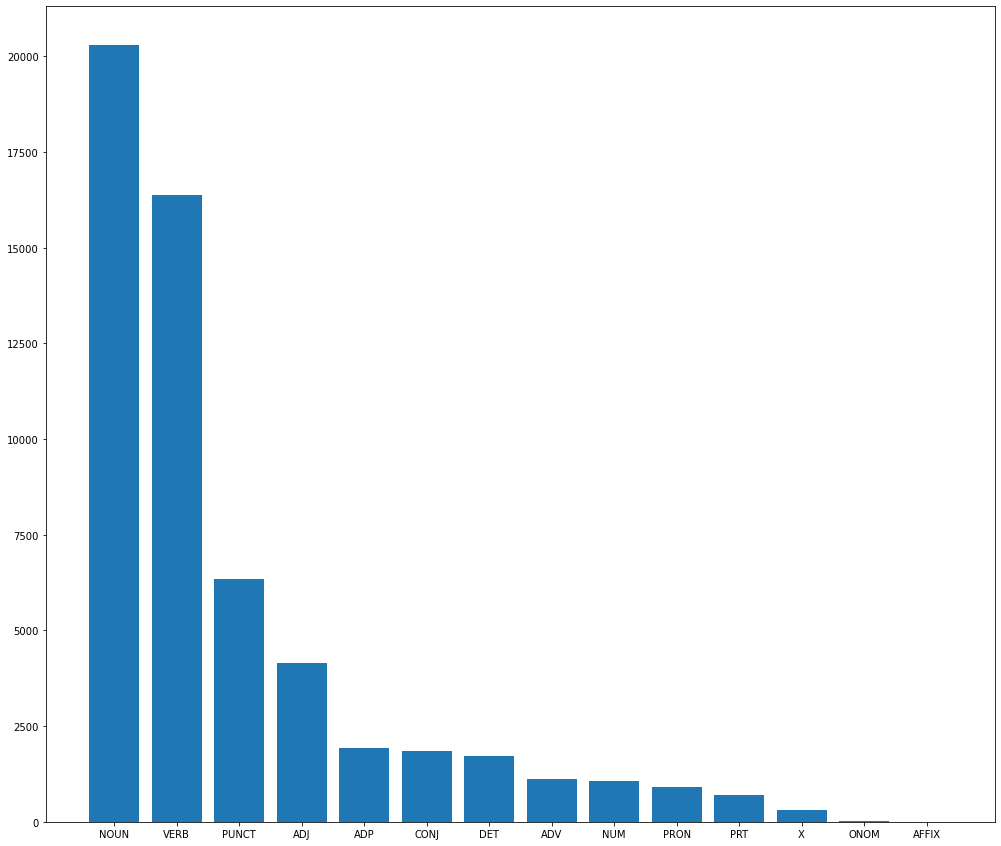

In [53]:
plot_pos(pos_extend_counts)

In [31]:
with open("/home/kara/Documents/Courses/Fall 2021/LING412 - RESEARCH & WRITING/Datasets/all_process/train.txt","w+", encoding="utf-8") as f_out:
    for pair in train_pairs_normalized:
        try:
            f_out.write(f"{pair[0]}\t{pair[1]}\t{pair[2]}\n")
        except:
            print(pair)

['']


## Feature Distribution

In [92]:
def get_max_feat_count(pairs):
    
    try:
        morphs = [token[1] for token in pairs]
    except:
        morphs = [token[1] for token in pairs[:-1]]

    feat_len = [len(token.split("+")[2:]) for token in morphs]
    return max(feat_len)

In [95]:
from collections import defaultdict

def create_df_from_pairs(pairs):

    max_feat_length = 0

    dict_df = dict()
    dict_df["token"] = []
    dict_df["Lemma"] = []
    dict_df["POS"] = []
    dict_df.update({f"Feature_{i}":pd.Series([pd.NA for i in range(len(pairs[:-1]))]) for i in range(get_max_feat_count(pairs))})

    for idx,(token, morphs,ID) in enumerate(pairs[:-1]):

        dict_df["token"].append(token)

        feats = morphs.split("+")

        dict_df["Lemma"].append(feats[0])
        dict_df["POS"].append(feats[1])

        for i,feat in enumerate(feats[2:]):
            dict_df[f"Feature_{i}"][idx] = feat
        
        dict_df["ID"] = ID

    df_pairs = pd.DataFrame(dict_df)

    return df_pairs

In [100]:
all_data = create_df_from_pairs(total_pairs)

In [101]:
all_data.head(10)

,token,Lemma,POS,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,...,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,ID
0,Burda,bur,PRON,PersonNumber=A3sg,Possessive=Pnon,Case=Loc,Proper=False,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
1,da,da,PRT,Proper=False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
2,öylemi,öyle,VERB,PersonNumber=A3sg,Possessive=Pnon,Case=Bare,Copula=PresCop,PersonNumber=V3sg,Proper=False,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
3,yoksa,yoksa,CONJ,ConjunctionType=Coor,Proper=False,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
4,kiloyla,kilo,VERB,PersonNumber=A3sg,Possessive=Pnon,Case=Ins,Copula=PresCop,PersonNumber=V3sg,Proper=False,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
5,mı,mı,PRT,Proper=False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
6,?,?,PUNCT,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
7,Açıklanmayan,açık,NOUN,PersonNumber=A3sg,Possessive=Pnon,Case=Bare,Proper=False,DB^VERB,Derivation=Make,Proper=False,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
8,soruların,soru,NOUN,PersonNumber=A3pl,Possessive=Pnon,Case=Gen,Proper=False,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071
9,müfredata,müfredat,NOUN,PersonNumber=A3sg,Possessive=Pnon,Case=Dat,Proper=False,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,http://tr.wikipedia.org/wiki/Megadeth:S071


In [102]:
all_data.fillna("Nan",inplace=True)
all_data.head()

,token,Lemma,POS,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,...,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,ID
0,Burda,bur,PRON,PersonNumber=A3sg,Possessive=Pnon,Case=Loc,Proper=False,Nan,Nan,Nan,...,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,http://tr.wikipedia.org/wiki/Megadeth:S071
1,da,da,PRT,Proper=False,Nan,Nan,Nan,Nan,Nan,Nan,...,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,http://tr.wikipedia.org/wiki/Megadeth:S071
2,öylemi,öyle,VERB,PersonNumber=A3sg,Possessive=Pnon,Case=Bare,Copula=PresCop,PersonNumber=V3sg,Proper=False,Nan,...,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,http://tr.wikipedia.org/wiki/Megadeth:S071
3,yoksa,yoksa,CONJ,ConjunctionType=Coor,Proper=False,Nan,Nan,Nan,Nan,Nan,...,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,http://tr.wikipedia.org/wiki/Megadeth:S071
4,kiloyla,kilo,VERB,PersonNumber=A3sg,Possessive=Pnon,Case=Ins,Copula=PresCop,PersonNumber=V3sg,Proper=False,Nan,...,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,Nan,http://tr.wikipedia.org/wiki/Megadeth:S071


In [23]:
all_data["POS"].value_counts()

NOUN     28973
VERB     11755
PUNCT     9048
ADJ       2943
ADP       2761
CONJ      2672
DET       2421
ADV       1591
NUM       1534
PRON      1284
PRT       1005
X          431
ONOM        13
             6
AFFIX        3
Name: POS, dtype: int64

In [103]:
feature_count = pd.Series(all_data[[f"Feature_{i}" for i in range(17)]].to_numpy().flatten()).value_counts(ascending=True)[1:]
feature_count

Derivation=ProNom           1
ComplementType=CAcc         2
Derivation=Ever             3
Derivation=Aff              3
Derivation=Inter            3
                        ...  
Case=Bare               21791
Possessive=Pnon         31025
PersonNumber=A3sg       32347
Proper=False            64852
Nan                    868644
Length: 125, dtype: int64

In [27]:
feature_count[-10:]

PersonNumber=V3sg      4249
Case=Nom               4491
Copula=PresCop         4706
Proper=True            7370
Possessive=P3sg        9089
Polarity=Pos          10830
Case=Bare             17684
Possessive=Pnon       31039
PersonNumber=A3sg     32354
Nan                  753496
dtype: int64

In [104]:
with open("feats.txt","w+", encoding="utf-8") as f_out:
    for feat in feature_count.index:
        f_out.write(f"\'{feat}\': r\'\'\n")

<BarContainer object of 125 artists>

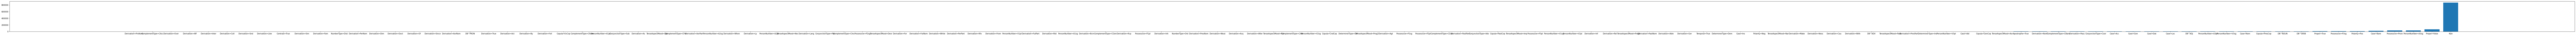

In [105]:
cropped = feature_count[:]
plt.rcParams['figure.figsize'] = [250, 3]
plt.bar(cropped.index, cropped.values)

In [106]:
cropped

Derivation=ProNom           1
ComplementType=CAcc         2
Derivation=Ever             3
Derivation=Aff              3
Derivation=Inter            3
                        ...  
Case=Bare               21791
Possessive=Pnon         31025
PersonNumber=A3sg       32347
Proper=False            64852
Nan                    868644
Length: 125, dtype: int64

In [107]:
def get_an_example(val_counts):
    samples = defaultdict(tuple)
    for feat, count in zip(val_counts.index, val_counts.values):
        ex = []
        for idx in range(16):
            results = all_data[all_data[f"Feature_{idx}"] == feat]
            if len(results) > 0:
                 ex.extend(results["token"])
                
        samples[f"{feat}"] = ex[0]
    return samples

In [108]:
for idx in range(16):
    results = all_data[all_data[f"Feature_{idx}"] == "Derivation=Lang"]
    if len(results) > 0:
         print(results["token"])

1547        İngilizce
3988         arapçada
6487           Türkçe
6781     ingilizceyle
17939          Türkçe
             ...     
63796    Türkmence'de
64995       Çupikçesi
65061       Fransızca
65069       Fransızca
65886          Türkçe
Name: token, Length: 76, dtype: object


In [109]:
def parse_rows(results):
    add_list = ["Lemma", "POS"]
    add_list.extend([f"Feature_{i}" for i in range(16)])
    data = []
    for i in results.index:
        data.append(" ".join([f"{token}" for token in all_data[add_list].loc[i].to_list() if token != "Nan"]))
    return data

In [111]:
train_pairs = [] 
val_pairs = []
test_pairs = []

dummy = all_data.copy(deep=True)

while dummy.shape[0] >= 1:
    try:
        feature_count = pd.Series(dummy[[f"Feature_{i}" for i in range(16)]].to_numpy().flatten()).value_counts(ascending=True)[:-1]

        feat = feature_count.index[0]
        indices = []
        data = []
        for idx in range(16):
            results = dummy[dummy[f"Feature_{idx}"] == feat]
            if len(results) > 0:
                data.extend(zip(list(results["token"]), parse_rows(results)))
                indices.extend(results.index)

        num_val_samples = int(0.15 * len(data))
        num_train_samples = len(data) - 2 * num_val_samples
        train_pairs.extend(data[:num_train_samples])
        val_pairs.extend(data[num_train_samples : num_train_samples + num_val_samples])
        test_pairs.extend(data[num_train_samples + num_val_samples :])

        dummy.drop(indices, inplace=True)
        print(feat)
        print("Remaining data:",dummy.shape[0])
        print("Remaining features:",len(feature_count))  
        print("*****************************")
        
    except:
        break

Derivation=Haste
Remaining data: 66442
Remaining features: 125
*****************************
Derivation=ProNom
Remaining data: 66441
Remaining features: 124
*****************************
ComplementType=CAcc
Remaining data: 66439
Remaining features: 123
*****************************
Derivation=Ever
Remaining data: 66436
Remaining features: 122
*****************************
Derivation=Aff
Remaining data: 66433
Remaining features: 121
*****************************
Derivation=Inter
Remaining data: 66430
Remaining features: 120
*****************************
Derivation=Snd
Remaining data: 66426
Remaining features: 119
*****************************
Derivation=Coll
Remaining data: 66422
Remaining features: 118
*****************************
Contrast=True
Remaining data: 66417
Remaining features: 117
*****************************
Derivation=Sim
Remaining data: 66412
Remaining features: 116
*****************************
Derivation=Like
Remaining data: 66407
Remaining features: 115
***************

In [112]:
pos_count = dummy["POS"].value_counts(ascending=True)

for pos in pos_count.index:
    
    indices = []
    data = []
    results = dummy[dummy[f"POS"] == pos]

    data.extend(zip(list(results["token"]), parse_rows(results)))
    indices.extend(results.index)

    num_val_samples = int(0.15 * len(data))
    num_train_samples = len(data) - 2 * num_val_samples
    train_pairs.extend(data[:num_train_samples])
    val_pairs.extend(data[num_train_samples : num_train_samples + num_val_samples])
    test_pairs.extend(data[num_train_samples + num_val_samples :])

    dummy.drop(indices, inplace=True)
    print(pos)
    print("Remaining data:",dummy.shape[0])
    print("Remaining features:",len(pos_count))  
    print("*****************************")


PUNCT
Remaining data: 0
Remaining features: 1
*****************************


In [113]:
print(len(dummy))

0


In [114]:
print(f"""
Size of training data: {len(train_pairs)} {len(train_pairs)/all_data.shape[0]}
Size of validation data: {len(val_pairs)} {len(val_pairs)/all_data.shape[0]}
Size of training data: {len(test_pairs)} {len(test_pairs)/all_data.shape[0]}
""")
print(all_data.shape[0])
print(len(train_pairs)+ len(val_pairs) + len(test_pairs))


Size of training data: 46628 0.7017744532907906
Size of validation data: 9911 0.1491654500850353
Size of training data: 9911 0.1491654500850353

66443
66450


In [115]:
train_final = []
for p in train_pairs:
    train_final.extend(p)
    
val_final = []
for p in val_pairs:
    val_final.extend(p)

test_final = []
for p in test_pairs:
    test_final.extend(p)

In [44]:
train_pairs = train_final
val_pairs = val_final
test_pairs = test_final

In [116]:
with open("train_dist.txt","w+", encoding="utf-8") as f_out:
    for token, feat in train_pairs:
        f_out.write(f"{token}\t{'+'.join(feat.split())}\n")
        
with open("val_dist.txt","w+", encoding="utf-8") as f_out:
    for token,feat in val_pairs:
        f_out.write(f"{token}\t{'+'.join(feat.split())}\n")
        
with open("test_dist.txt","w+", encoding="utf-8") as f_out:
    for token,feat in test_pairs:
        f_out.write(f"{token}\t{'+'.join(feat.split())}\n")

In [40]:
get_an_example(cropped[:])

defaultdict(tuple,
            {'PersonNumber=V1pl': 'biliyoruzdur',
             'Derivation=From': 'Yerli',
             'Derivation=Rfx': 'sevinirim',
             'Derivation=PerPart': 'korkmuş',
             'Derivation=While': 'iken',
             'Derivation=FutNom': 'olacağını',
             'Derivation=For': ")'lik",
             'TenseAspectMood=Desr': 'etsem',
             'Possessive=P2sg': 'Aygıtınız',
             'ComplementType=CIns': 'birlikte',
             'ConjunctionType=Par': 'ne',
             'Derivation=Lang': 'İngilizce',
             'TenseAspectMood=Nec': 'kullanmamalısınız',
             'PersonNumber=A2pl': 'sizlerle',
             'Derivation=Ly': 'olasıca',
             'Derivation=When': 'deyince',
             'PersonNumber=A2sg': 'seninle',
             'Derivation=AorPart': 'güler',
             'ComplementType=CFin': 'diye',
             'TenseAspectMood=Opt': 'Diyelimki',
             'Derivation=As': 'oldukça',
             'ConjunctionType=Sub': 

In [59]:
feature_index = pd.Series(all_data[[f"Feature_{i}" for i in range(16)]].to_numpy().flatten()).index
feature_index

RangeIndex(start=0, stop=1063040, step=1)

In [76]:
train_pairs[0][1].split()[1]

'VERB'

In [109]:
train_pos = pd.Series([token[1].split(" ")[1] for token in train_pairs]).value_counts()
val_pos =  pd.Series([token[1].split(" ")[1] for token in val_pairs]).value_counts()
test_pos =  pd.Series([token[1].split(" ")[1] for token in test_pairs]).value_counts()

In [80]:
_,train_feats = get_tag_counts(train_pairs)
_,val_feats = get_tag_counts(val_pairs)
_,test_feats = get_tag_counts(test_pairs)

In [102]:
for idx in val_feats.index:
    print(f"{idx}:\t\tTrain:{train_feats[idx]} Val:{val_feats[idx]} Test:{test_feats[idx]}")
    print("********************")
    

PersonNumber=A3sg:		Train:22043 Val:4778 Test:5533
********************
Possessive=Pnon:		Train:21425 Val:4511 Test:5107
********************
Case=Bare:		Train:14649 Val:3278 Test:3876
********************
Polarity=Pos:		Train:7657 Val:1715 Test:1907
********************
Possessive=P3sg:		Train:6099 Val:1461 Test:1529
********************
Proper=True:		Train:4558 Val:1206 Test:1606
********************
Copula=PresCop:		Train:3380 Val:673 Test:654
********************
PersonNumber=V3sg:		Train:2985 Val:668 Test:598
********************
Case=Nom:		Train:3225 Val:631 Test:635
********************
PersonNumber=A3pl:		Train:2870 Val:602 Test:592
********************
Case=Loc:		Train:2487 Val:543 Test:596
********************
Derivation=Pass:		Train:847 Val:495 Test:710
********************
Case=Dat:		Train:1987 Val:389 Test:417
********************
Case=Gen:		Train:1773 Val:377 Test:378
********************
ConjunctionType=Coor:		Train:1538 Val:329 Test:329
********************
Case=Acc:		T

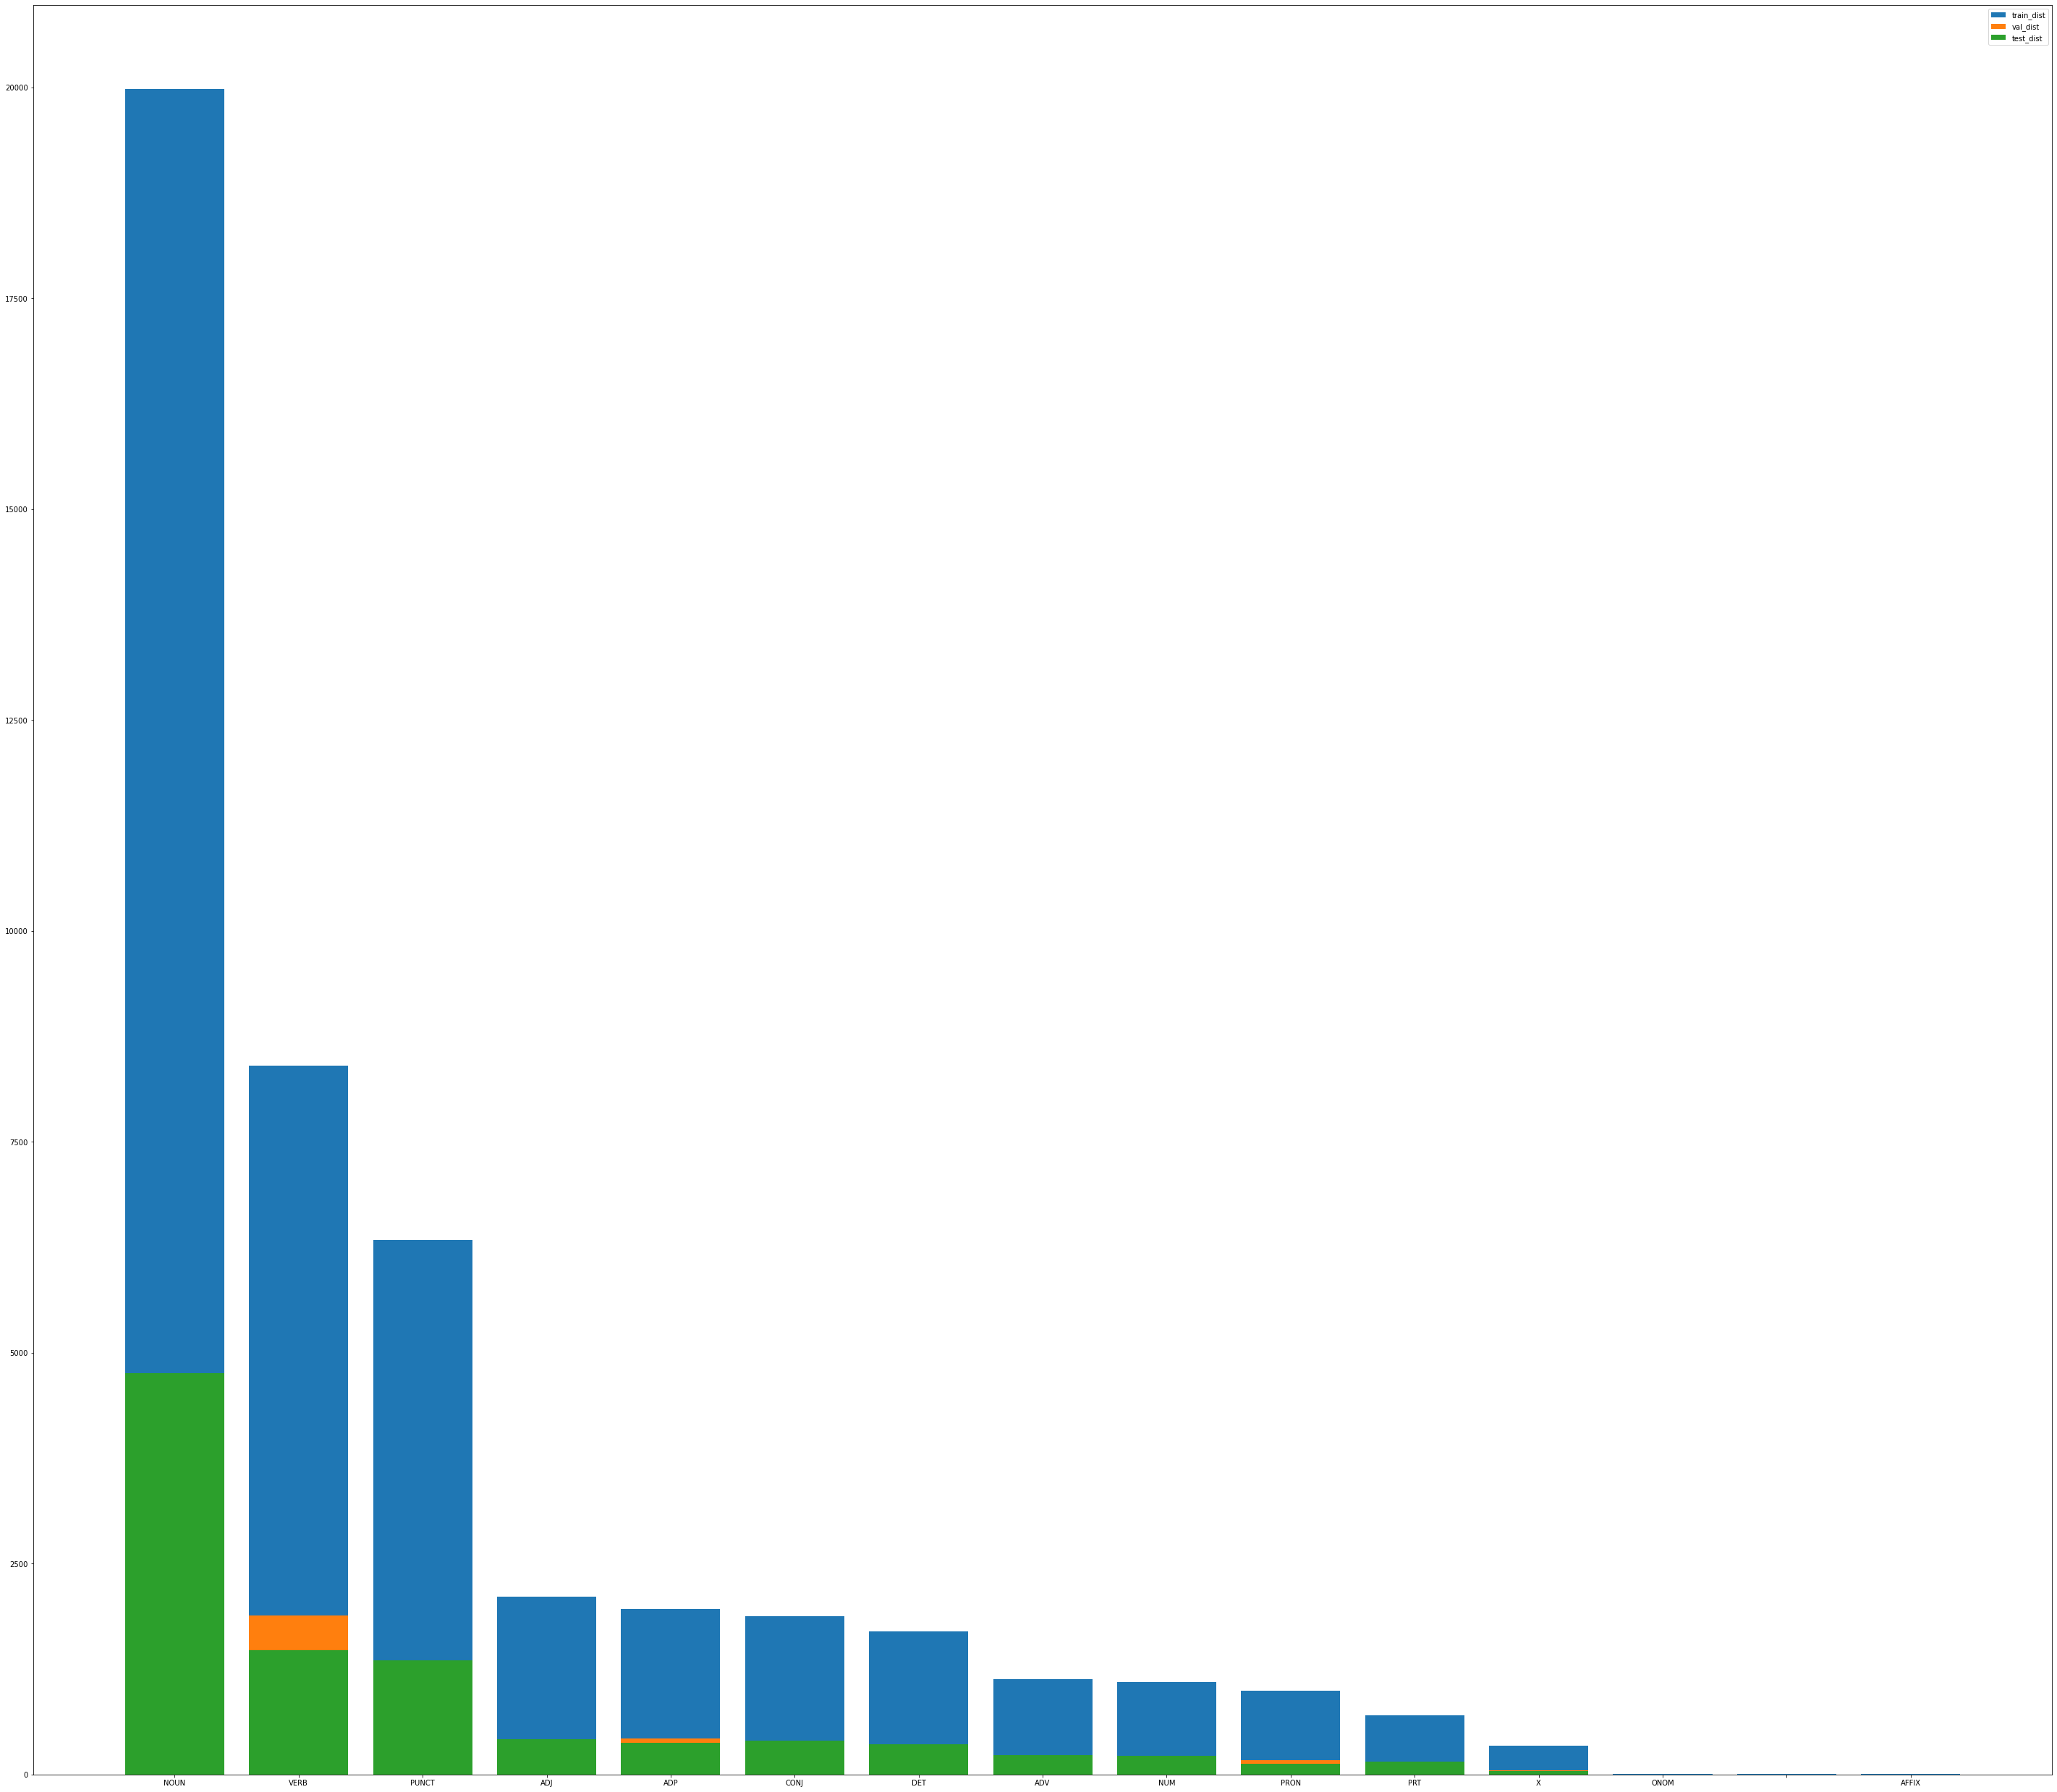

In [114]:
plt.rcParams['figure.figsize'] = [50, 45]

plt.bar(train_pos.index, train_pos.values, label = "train_dist")
plt.bar(val_pos.index, val_pos.values, label = "val_dist")
plt.bar(test_pos.index, test_pos.values, label = "test_dist")
plt.legend()
plt.show()

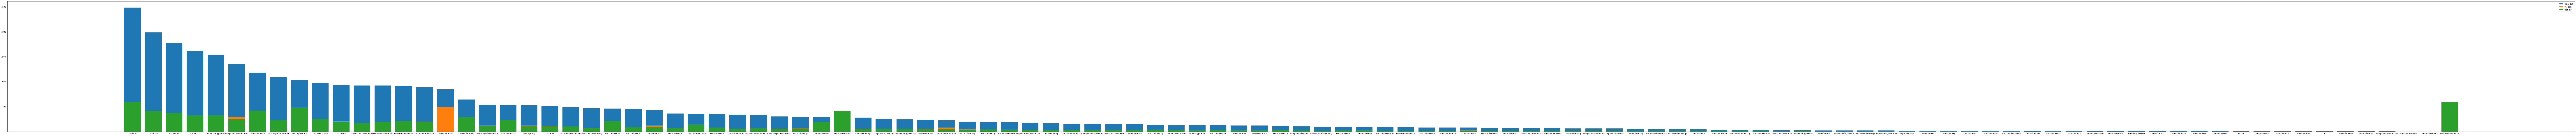

In [105]:
plt.rcParams['figure.figsize'] = [250, 13]

plt.bar(train_feats[10:].index, train_feats[10:].values, label = "train_dist")
plt.bar(val_feats[10:].index, val_feats[10:].values, label = "val_dist")
plt.bar(test_feats[10:].index, test_feats[10:].values, label = "test_dist")
plt.legend()
plt.show()

In [108]:
pd.DataFrame({"TRAIN": train_pos,
             "VAL": val_pos,
             "TEST": test_pos}, dtype="int64").sort_values(by="TRAIN",ascending=False).head(20)

,TRAIN,VAL,TEST
NOUN,19979,4232.0,4761.0
VERB,8400,1889.0,1473.0
PUNCT,6334,1357.0,1357.0
ADJ,2106,422.0,415.0
ADP,1965,424.0,372.0
CONJ,1874,399.0,399.0
DET,1699,361.0,361.0
ADV,1126,232.0,233.0
NUM,1093,220.0,221.0
PRON,989,171.0,124.0


In [94]:
pd.DataFrame({"TRAIN": train_feats,
             "VAL": val_feats,
             "TEST": test_feats}, dtype="int64").sort_values(by="TRAIN",ascending=False).head(20)

,TRAIN,VAL,TEST
PersonNumber=A3sg,22043,4778.0,5533.0
Possessive=Pnon,21425,4511.0,5107.0
Case=Bare,14649,3278.0,3876.0
Polarity=Pos,7657,1715.0,1907.0
Possessive=P3sg,6099,1461.0,1529.0
Proper=True,4558,1206.0,1606.0
Copula=PresCop,3380,673.0,654.0
Case=Nom,3225,631.0,635.0
PersonNumber=V3sg,2985,668.0,598.0
PersonNumber=A3pl,2870,602.0,592.0
